# I. Dataset Description:

The MovieLens small dataset (ml-latest-small) is a publicly available dataset that contains 100,836 ratings and 3,683 tag applications applied to 9,742 movies by 610 users. This dataset is part of the MovieLens project, which is a research site run by GroupLens Research at the University of Minnesota. The dataset is designed for educational and research purposes, and it is commonly used for building recommendation systems. These data were created between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

The small dataset contains four files:

* `ratings.csv:` It contains the user id, movie id, rating, and timestamp of 100,000 ratings.

* `movies.csv:` It contains the movie id, title, and genres of 10,000 movies.

* `tags.csv:` It contains the user id, movie id, and tag of 9,000 tag applications.

* `links.csv:` It contains the movie id, IMDB id, and TMDb id of 10,000 movies.

This dataset can be downloaded from the official website of the MovieLens project: 
https://grouplens.org/datasets/movielens/latest/

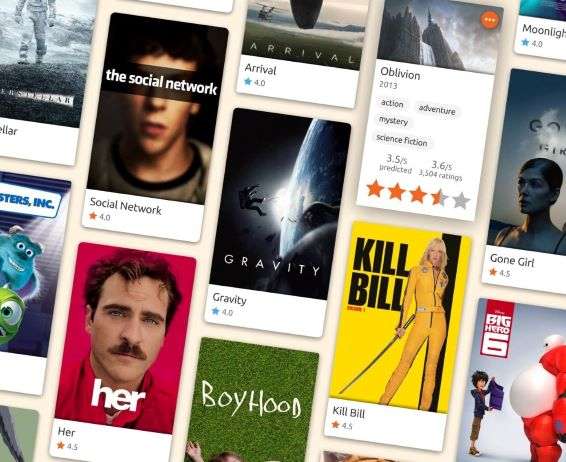


# II. ETL Process:

The Extract, Transform, and Load (ETL) process is a crucial step in the data warehousing process, as it is responsible for moving and manipulating data from various source systems into the data warehouse. The ETL process is typically broken down into three distinct stages.

## Import necessary Libraries:

In [1]:
import pandas as pd
from fuzzywuzzy import process,  fuzz
import datetime as dt
import pyodbc
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## 1.Extraction

Extract the data from its various sources, such as the ratings, movies, tags and links files provided by the MovieLens project.

In [2]:
#consist of movie titles and genres
movie_df = pd.read_csv('ml-latest-small/movies.csv')
#consisit of  ratings
rating_df = pd.read_csv('ml-latest-small/ratings.csv')
#consist of tags/comments from users
tag_df = pd.read_csv('ml-latest-small/tags.csv')
#consist of movie links
link_df = pd.read_csv('ml-latest-small/links.csv')

## 2.Transformation:

In this step, data is cleaned, filtered, and transformed so that it can be loaded into the data warehouse.

<h1 style='background:#6EA5C4;padding-top:1px; border:0; color:white'><center>movies.csv</center></h1> 

### a. Data Merging:

Since links.csv contains imdbID and tmdbId of movies, it will be best to merge it with the movie table.

In [3]:
#merge data
#Join with other tables
movie_df = movie_df.join(link_df.set_index('movieId'), on='movieId')


In [4]:
movie_df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Advent|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Roman,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comdy,113041,11862.0


In [5]:
movie_df.shape

(9742, 5)

In [6]:
movie_df.columns

Index(['movieId', 'title', 'genres', 'imdbId', 'tmdbId'], dtype='object')

In [7]:
movie_df.dtypes

movieId      int64
title       object
genres      object
imdbId       int64
tmdbId     float64
dtype: object

In [8]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
imdbId     0
tmdbId     8
dtype: int64

### b. Data Cleaning

In [9]:
# Remove duplicate rows
movie_df = movie_df.drop_duplicates()

### c. Data Sorting

In [10]:
movie_df = movie_df.sort_values(by=['movieId'])

### d. Data Normalization

In [11]:
# Data standardization
movie_df['genres'] =  movie_df['genres'].str.lower()


### e. Data Splitting

In [12]:
#Parsing
# Extract year from title
movie_df['year'] = movie_df['title'].str.findall('\((\d{4})\)').str.get(0)
movie_df['title'] = movie_df['title'].str.split(r'\(').str.get(0)

In [13]:
#seperate genre for each movie and count genres
genres = movie_df['genres'].str.split(pat='|', expand=True).fillna(0)
genres.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
cols = genres.columns
genres[cols] = genres[cols].astype('category')
g = genres.copy()
cat_columns = g.select_dtypes(['category']).columns


### f. Data Derivation

In [14]:
#count genres (non zeros)
g[cat_columns] = g[cat_columns].apply(lambda x: x.cat.codes)
g['genre_count'] = g[cols].gt(0).sum(axis=1) #count greater than 0 values for less than: df[cols].lt(0).sum(axis=1), for equal==0: df[cols].eq(0).sum(axis=1)


In [15]:
#assigning everything to same dataframe
movie_df['genre_count'] = g['genre_count']
movie_df[cols] = genres[cols]

movie_df = movie_df.drop(['genres'], axis=1)

### g. Data Type Conversion

In [16]:
movie_df['imdb_url'] = movie_df['imdbId'].apply(lambda imdbId : 'https://www.imdb.com/title/tt{}/'.format(imdbId if imdbId >= 1000000 else "0" + str(imdbId)))
movie_df.drop(columns = ['imdbId', 'tmdbId'], axis = 1, inplace = True)

# convert the year column to int
movie_df["year"] = pd.to_numeric(movie_df["year"], errors='coerce').fillna(0).astype(int)

for c in ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']:
    movie_df[c] = movie_df[c].astype("category")


### h. Fuzzy String Matching

In [17]:
#String matching
distinct_genres = ['adventure', 'animation', 'children', 'comedy', 'fantasy', 'drama', 'romance', 'action', 'crime', 
          'thriller', 'horror', 'mystery', 'sci-fi', 'war', 'musical', 'documentary', 'imax', 'western', 'film-noir',
          '(no genres listed)']

In [18]:
# Function to correct genre names
def correct_genre(genre):
    if not pd.isna(genre):  # check if the genre is not NaN
        result = process.extractOne(str(genre), distinct_genres, score_cutoff=80, scorer=fuzz.token_set_ratio)
        if result:
            new_genre, score = result
            return new_genre
        else:
            return genre
    else: 
        return None

In [19]:
#cols = genres.columns
for genre in cols:
    movie_df[genre] = movie_df[genre].map(correct_genre)

## -------------------------------------------------------------------------------------------------------------------------------


In [20]:
movie_df.head(6)

,movieId,title,year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,imdb_url
0,1,Toy Story,1995,5,adventure,animation,children,comedy,fantasy,0,0,0,0,0,https://www.imdb.com/title/tt0114709/
1,2,Jumanji,1995,3,adventure,children,fantasy,0,0,0,0,0,0,0,https://www.imdb.com/title/tt0113497/
2,3,Grumpier Old Men,1995,2,comedy,romance,0,0,0,0,0,0,0,0,https://www.imdb.com/title/tt0113228/
3,4,Waiting to Exhale,1995,3,comedy,drama,romance,0,0,0,0,0,0,0,https://www.imdb.com/title/tt0114885/
4,5,Father of the Bride Part II,1995,1,comedy,0,0,0,0,0,0,0,0,0,https://www.imdb.com/title/tt0113041/
5,6,Heat,1995,3,action,crime,thriller,0,0,0,0,0,0,0,https://www.imdb.com/title/tt0113277/


In [21]:
movie_df.shape

(9742, 15)

In [54]:
movie_df.columns

Index(['movieId', 'title', 'year', 'genre_count', 'genre1', 'genre2', 'genre3',
       'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10',
       'imdb_url'],
      dtype='object')

In [55]:
movie_df.dtypes

movieId           int64
title            object
year              int32
genre_count       int64
genre1         category
genre2         category
genre3         category
genre4         category
genre5         category
genre6         category
genre7         category
genre8         category
genre9         category
genre10        category
imdb_url         object
dtype: object

In [24]:
movie_df.isnull().sum()

movieId        0
title          0
year           0
genre_count    0
genre1         0
genre2         0
genre3         0
genre4         0
genre5         0
genre6         0
genre7         0
genre8         0
genre9         0
genre10        0
imdb_url       0
dtype: int64

## -------------------------------------------------------------------------------------------------------------------------------

<h1 style='background:#6EA5C4;padding-top:1px; border:0; color:white'><center>ratings.csv</center></h1> 

In [25]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [26]:
rating_df.shape

(100836, 4)

In [27]:
rating_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [28]:
rating_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [29]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### a. Data Cleaning

In [30]:
# Remove duplicate rows
rating_df = rating_df.drop_duplicates()

In [31]:
# Handle Outliers
rating_df = rating_df[(rating_df['rating'] > 0) & (rating_df['rating'] <= 5)]

### b. Data Sorting

In [32]:
rating_df = rating_df.sort_values(by=['movieId'])

### c. Data Binning

In [33]:
#Binning
# Bin ratings into three categories: low, medium, and high
rating_df['rating_category'] = pd.cut(rating_df['rating'], bins=[0, 3, 4, 5], labels=['low', 'medium', 'high'])

### d. Data Type Conversion

In [34]:
#Timestamp transformation
# Convert timestamp column to datetime format
rating_df['date'] = pd.DatetimeIndex(rating_df['timestamp']).date
# Drop the timestamp column
rating_df.drop(columns=['timestamp'], inplace=True)


### e. Data Formatting

In [35]:
rating_df['date'] = pd.to_datetime(rating_df['date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

## ----------------------------------------------------------------------------------------------------------------------------

In [36]:
rating_df.head(6)

,userId,movieId,rating,rating_category,date
0,1,1,4.0,medium,01-01-1970
81531,517,1,4.0,medium,01-01-1970
30517,213,1,3.5,medium,01-01-1970
81082,514,1,4.0,medium,01-01-1970
30601,214,1,3.0,low,01-01-1970
30721,216,1,3.0,low,01-01-1970


In [37]:
rating_df.columns

Index(['userId', 'movieId', 'rating', 'rating_category', 'date'], dtype='object')

In [38]:
rating_df.dtypes

userId                int64
movieId               int64
rating              float64
rating_category    category
date                 object
dtype: object

In [39]:
rating_df.isnull().sum()

userId             0
movieId            0
rating             0
rating_category    0
date               0
dtype: int64

## -------------------------------------------------------------------------------------------------------------------------------

<h1 style='background:#6EA5C4;padding-top:1px; border:0; color:white'><center>tags.csv</center></h1> 

In [40]:
tag_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [41]:
tag_df.shape

(3683, 4)

In [42]:
tag_df.columns

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

In [43]:
tag_df.dtypes

userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

In [44]:
tag_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

### a. Data Cleaning

In [45]:
# Remove duplicate rows
tag_df = tag_df.drop_duplicates()

### b. Data Sorting

In [46]:
tag_df = tag_df.sort_values(by=['movieId'])

### c. Data Normalization

In [47]:
# Data standardization
tag_df['tag'] = tag_df['tag'].str.lower()

### d. Data Filtering

In [48]:
#drop userId and Timestamp column
tag_df = tag_df.drop(['timestamp'], axis=1)
#tag_df = tag_df[tag_df.duplicated(['userId', 'movieId'])]

## -------------------------------------------------------------------------------------------------------------------------------

In [73]:
tag_df.head(6)

,userId,movieId,tag
2886,567,1,fun
981,474,1,pixar
629,336,1,pixar
35,62,2,robin williams
34,62,2,magic board game
33,62,2,fantasy


In [51]:
tag_df.columns

Index(['userId', 'movieId', 'tag'], dtype='object')

In [52]:
tag_df.dtypes

userId      int64
movieId     int64
tag        object
dtype: object

In [53]:
tag_df.isnull().sum()

userId     0
movieId    0
tag        0
dtype: int64

## -------------------------------------------------------------------------------------------------------------------------------

## 3. Loading

In [56]:
# Connect to the database
database = pyodbc.connect('Driver={SQL Server};'
                      'Server=HAFIDA\SQLSERVER19;'
                      'Database=DWR;'
                      'Trusted_Connection=yes;')
cursor = database.cursor()

In [57]:
cursor.execute("SET LOCK_TIMEOUT 1800;")
# Create the table in the database
cursor.execute('''
		CREATE TABLE movies (
    movieId INT PRIMARY KEY,
    title VARCHAR(255),
    year INT,
    genre_count INT,
    genre1 VARCHAR(255),
    genre2 VARCHAR(255),
    genre3 VARCHAR(255),
    genre4 VARCHAR(255),
    genre5 VARCHAR(255),
    genre6 VARCHAR(255),
    genre7 VARCHAR(255),
    genre8 VARCHAR(255),
    genre9 VARCHAR(255),
    genre10 VARCHAR(255),
    imdb_url VARCHAR(255)
)
               ''')

cursor.execute('''COMMIT TRANSACTION;''')

In [58]:
# Insert the data into the SQL table
for index, row in movie_df.iterrows():
    cursor.execute("INSERT INTO [dbo].[movies]([movieId] ,[title] ,[year] ,[genre_count] ,[genre1] ,[genre2] ,[genre3] ,[genre4] ,[genre5] ,[genre6] ,[genre7] ,[genre8] ,[genre9] ,[genre10] ,[imdb_url]) VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", row['movieId'] ,row['title'] ,row['year'] ,row['genre_count'] ,row['genre1'] ,row['genre2'] ,row['genre3'] ,row['genre4'] ,row['genre5'] ,row['genre6'] ,row['genre7'] ,row['genre8'] ,row['genre9'] ,row['genre10'] ,row['imdb_url'])
    database.commit()

In [59]:
# Extract distinct userIds from rating_df and tag_df
userIds_df = pd.concat([rating_df['userId'], tag_df['userId']]).drop_duplicates()

In [60]:
cursor.execute('''
		CREATE TABLE users (
  userId INTEGER PRIMARY KEY
)
               ''')

cursor.execute('''COMMIT TRANSACTION;''')

In [61]:
# Insert the distinct userIds into the users table
for userId in userIds_df:
    cursor.execute("INSERT INTO users (userId) VALUES (?)", (userId,))

#commit the transaction
database.commit()

In [62]:
cursor.execute("SET LOCK_TIMEOUT 1800;")

cursor.execute('''
		CREATE TABLE ratings (
  userId INTEGER NOT NULL,
  movieId INTEGER NOT NULL,
  rating FLOAT,
  rating_category VARCHAR(255),
  date DATE NOT NULL,
  PRIMARY KEY (userId, movieId),
  FOREIGN KEY (movieId) REFERENCES movies(movieId),
  FOREIGN KEY (userId) REFERENCES users(userId)
)
               ''')

cursor.execute('''COMMIT TRANSACTION;''')

In [63]:
# Insert the data into the ratings table
for index, row in rating_df.iterrows():
    cursor.execute("INSERT INTO [dbo].[ratings]([userId], [movieId], [rating], [rating_category], [date]) VALUES (?,?,?,?,?)", row['userId'], row['movieId'], row['rating'], row['rating_category'], row['date'])
    database.commit()

In [68]:
cursor.execute("SET LOCK_TIMEOUT 1800;")
cursor.execute('''
		CREATE TABLE tags (
  id INTEGER NOT NULL IDENTITY(1, 1),
  userId INTEGER NOT NULL,
  movieId INTEGER NOT NULL,
  tag VARCHAR(255) NOT NULL,
  PRIMARY KEY(id),
  FOREIGN KEY (movieId) REFERENCES movies(movieId),
  FOREIGN KEY (userId) REFERENCES users(userId)
)
               ''')

cursor.execute('''COMMIT TRANSACTION;''')

In [69]:
# Insert the data into the tag table
for index, row in tag_df.iterrows():
    cursor.execute("INSERT INTO [dbo].[tags]([userId], [movieId], [tag]) VALUES (?,?,?)", row['userId'], row['movieId'], row['tag'])
    database.commit()

In [70]:
# Close the connection
cursor.close()
database.close()